In [6]:
library(tidyverse)
library(readxl)
library(ggplot2)
library(cowplot)

Warning message:
“package ‘cowplot’ was built under R version 4.3.2”

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
url <- "https://archive.ics.uci.edu/static/public/257/user+knowledge+modeling.zip"
temp <- tempfile()
temp2 <- tempfile()

download.file(url, temp)
unzip(zipfile = temp, exdir = temp2)
data_training <- read_excel(file.path(temp2, "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls"), sheet = 2) #training data
data_testing <- read_excel(file.path(temp2, "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls"), sheet = 3)  #testing data
unlink(c(temp, temp2))

slice(data_training, 1:10) #sliced so as not to clog screen

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low,NA,NA,"STG (The degree of study time for goal object materails),"
0.08,0.08,0.10,0.24,0.90,High,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,STR (The degree of study time of user for related objects with goal object)
0.10,0.10,0.15,0.65,0.30,Middle,NA,NA,LPR (The exam performance of user for related objects with goal object)
0.08,0.08,0.08,0.98,0.24,Low,NA,NA,PEG (The exam performance of user for goal objects)
0.09,0.15,0.40,0.10,0.66,Middle,NA,NA,UNS (The knowledge level of user)
0.10,0.10,0.43,0.29,0.56,Middle,NA,NA,NA
0.15,0.02,0.34,0.40,0.01,very_low,NA,NA,NA
0.20,0.14,0.35,0.72,0.25,Low,NA,NA,NA


In [15]:
knowledge_training <- select(data_training, STG:UNS) #selected useful columns
slice(knowledge_training, 1:10) #sliced so as not to clog screen 

summary_knowledge_training <- knowledge_training |>   # this table shows the total amount of observations per knowledge lvl
    group_by(UNS) |>                                  # and the mean values for each predictor for each knowledge lvl
    summarize(count = n(),
             STG_mean = mean(STG),
             STR_mean = mean(STG),
             LPG_mean = mean(STG),
             PEG_mean = mean(STG))

summary_knowledge_training

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low


UNS,count,STG_mean,STR_mean,LPG_mean,PEG_mean
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
High,63,0.4216508,0.4216508,0.4216508,0.4216508
Low,83,0.3211446,0.3211446,0.3211446,0.3211446
Middle,88,0.3999773,0.3999773,0.3999773,0.3999773
very_low,24,0.3057917,0.3057917,0.3057917,0.3057917


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


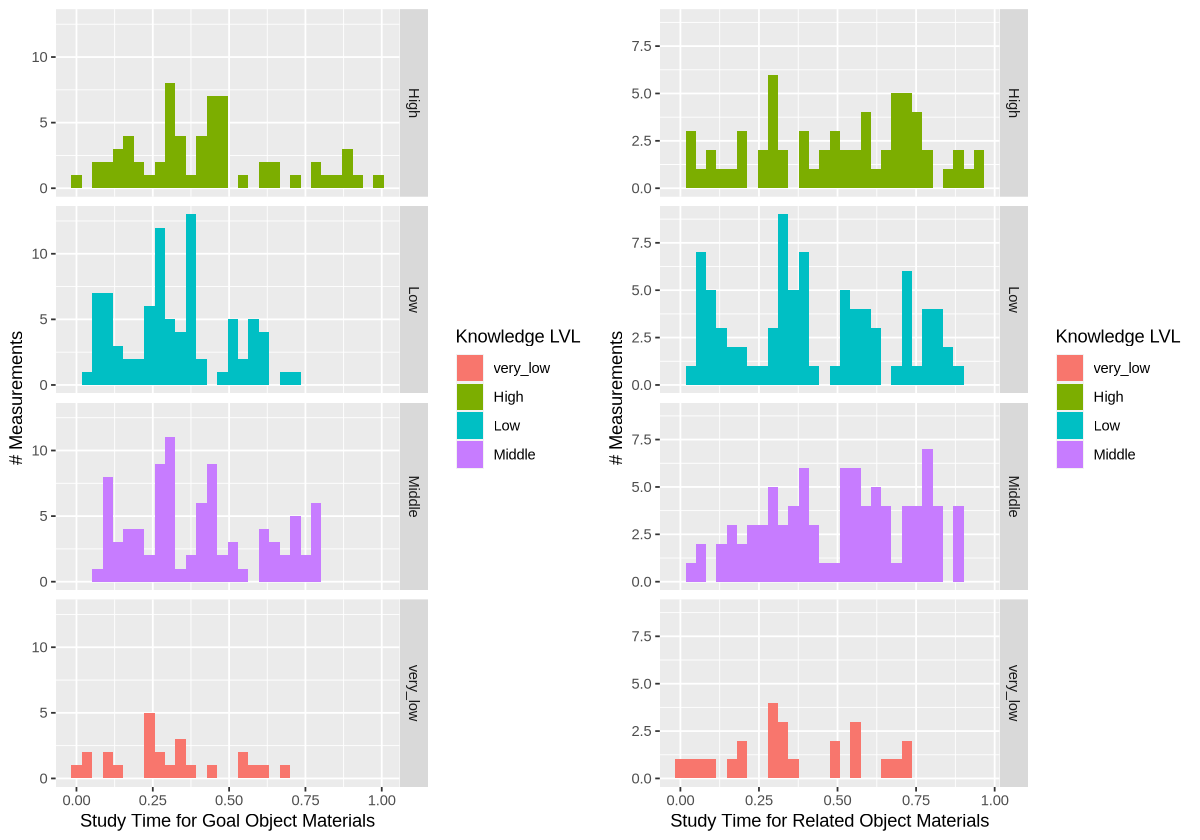

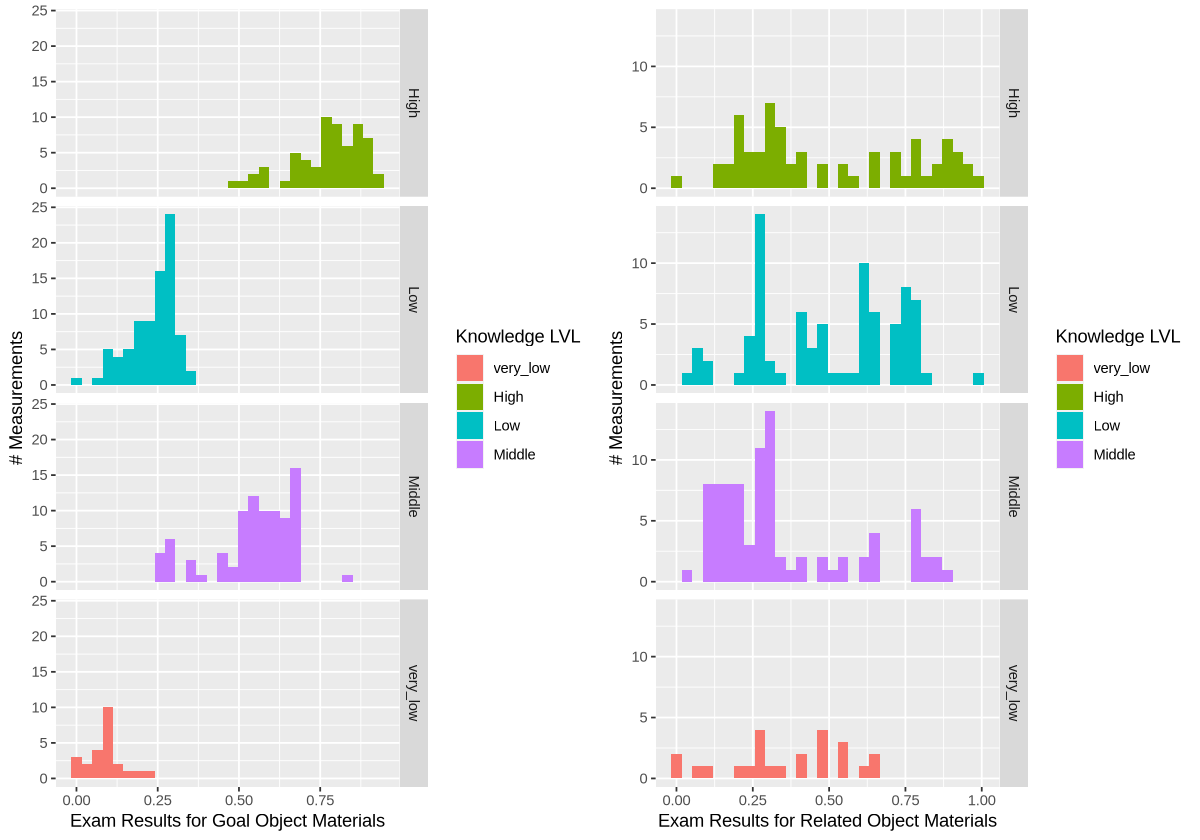

In [10]:
options(repr.plot.width = 10, repr.plot.height = 7)
knowledge_STG_hist <- ggplot(knowledge_training, aes(x = STG, fill = as_factor(UNS))) +
  geom_histogram() +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Study Time for Goal Object Materials", y = "# Measurements", fill = "Knowledge LVL")




knowledge_STR_hist <- ggplot(knowledge_training, aes(x = STR, fill = as_factor(UNS))) +
  geom_histogram() +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Study Time for Related Object Materials", y = "# Measurements", fill = "Knowledge LVL")




knowledge_PEG_hist <- ggplot(knowledge_training, aes(x = PEG, fill = as_factor(UNS))) +
  geom_histogram() +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Exam Results for Goal Object Materials", y = "# Measurements", fill = "Knowledge LVL")




knowledge_LPR_hist <- ggplot(knowledge_training, aes(x = LPR, fill = as_factor(UNS))) +
  geom_histogram() +
  facet_grid(rows = vars(UNS)) +
  labs(x = "Exam Results for Related Object Materials", y = "# Measurements", fill = "Knowledge LVL")

plot_grid(knowledge_STG_hist, knowledge_STR_hist)  # plots showing the distributions of each predictor
plot_grid(knowledge_PEG_hist, knowledge_LPR_hist)

!Title:


**Introduction:**

In this project, we delve into a dataset focused on assessing students' knowledge status in the subject of **Electrical DC Machines**. Our objective is to analyze **Users' knowledge levels** based on various factors.

Our focus lies in uncovering the correlation between users' knowledge levels and specific variables. These variables include:

`STG` :The degree of study time for goal object materails)

`SCG` :The degree of repetition number of user for goal object materails)

`STR` (Study Time Ratio): The degree of study time of user for related objects with goal object

`LPR` (Learning Performance Ratio): The exam performance of user for related objects with goal object

`PEG` (Performance Evaluation Grade): The exam performance of user for goal objects

`UNS` :The knowledge level of user

>By analyzing this dataset, we aim to clearly discern the classcification of users' knowledge levels across the defined categories: *very_low, Low, Middle, and High*. Understanding these knowledge levels is crucial for optimizing educational strategies and interventions in this particular subject.

Based on the given, we are going to use the most *three* efficient and helpful varibles, `STR`, `LPR`,`PEG` to show our classcification of the results `UNS`(The knowledge level of user).